# AGUENIER Justin et ROUAULT Martin

# TP Advanced machine learning : Part I

In [1]:
!wget http://go.criteo.net/criteo-ppml-challenge-adkdd21-dataset.zip
!unzip criteo-ppml-challenge-adkdd21-dataset.zip
!rm aggregated_noisy_data_pairs.csv.gz aggregated_noisy_data_singles.csv.gz  
!gunzip X_test.csv.gz X_train.csv.gz y_test.csv.gz y_train.csv.gz
!rm criteo-ppml-challenge-adkdd21-dataset.zip
!sed -n 1,10000p X_test.csv > X_valid.csv #CARE we took 10k lines from test as validation.
!sed -n 1,10000p y_test.csv > y_valid.csv

--2022-01-15 14:44:25--  http://go.criteo.net/criteo-ppml-challenge-adkdd21-dataset.zip
Resolving go.criteo.net (go.criteo.net)... 178.250.0.152
Connecting to go.criteo.net (go.criteo.net)|178.250.0.152|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://criteostorage.blob.core.windows.net/criteo-research-datasets/criteo_ppml_challenge_adkdd2021/criteo-ppml-challenge-adkdd21-dataset.zip [following]
--2022-01-15 14:44:25--  https://criteostorage.blob.core.windows.net/criteo-research-datasets/criteo_ppml_challenge_adkdd2021/criteo-ppml-challenge-adkdd21-dataset.zip
Resolving criteostorage.blob.core.windows.net (criteostorage.blob.core.windows.net)... 20.209.1.1
Connecting to criteostorage.blob.core.windows.net (criteostorage.blob.core.windows.net)|20.209.1.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 297834690 (284M) [application/zip]
Saving to: ‘criteo-ppml-challenge-adkdd21-dataset.zip’

criteo-ppml-challen 100%[=========

## Answer question 1 : 

To answer that question we introduce the matrix ```v``` that has a ```(D,K)``` shape. After that we modified the ```get_p``` and ```update_w``` functions : 
- ```get_p_factorization``` takes into account the $\sum_{i=1}^{n}\sum_{j=i+1}^{n} x_i x_j v_{i, j}$ part.
- ```update_wL2_factorization``` update the values for the matrix ```v``` with an L2 regularization. For the matrix ```v``` terms we use the partial derivative for $v_{i,f}$ of the matrix ```v``` given by $x_{i} \sum_{j=1}^{n} v_{j, f} x_{j}-v_{i, f} x_{i}^{2}$ 

We use the formulation of the model : $w_{0} + \sum_{i=1}^{n} w_{i} x_{i} + \frac{1}{2} \sum_{f=1}^{k} \left( \left( \sum_{i}^{n} v_{i,f}x_{i} \right)^2  - \sum_{i=1}^{n} v_{i,f}^2 x_{i}^2 \right)$ (see original paper), that enables to access all parameters in $\mathcal{O}(n*k)$ instead of $\mathcal{O}(n^{2})$.

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
from datetime import datetime
from csv import DictReader
from math import exp, log, sqrt


def get_x(csv_row, D):
    """
    Apply hash trick for the original csv row
    :param csv_row: csv dictionnary ex : {'hash_1': '357', 'hash_2': '', ...}
    :param D:int: max index that we can hash
    :return : list: return a list of indices to find the corresponding weights.
    """
    x = []
    for key, value in csv_row.items():
        index = int(value + key[4:], 16) % D
        x.append(index)
    x.append(0)
    return x


def logloss(p, y):
    """
    :param p:float:prediction of a model
    :param y:int: real answer
    """
    p = max(min(p, 1. - 10e-12), 10e-12)
    return -log(p) if y == 1. else -log(1. - p)

def compute_validation_loss_factorization(w, D, v, k):
    """
    Function that computes to the loss for the fatorization machine method
    :param w: list : weights 
    :param D: int : number of weights possible 
    :param v: numpy ndarray :factorization matrix
    :param k: int: number of factors
    
    """
    val_loss = 0
    for t, (row, y) in enumerate(zip(DictReader(open(X_valid)), DictReader(open(y_valid)))):
        x = get_x(row, D)
        p = get_p_factorization(x, w, v, k)
        target = float(y['click'])
        val_loss += logloss(p, target)
    return val_loss / t


def get_p_factorization(x, w, v, k):
    """ Function that return the prediction given the parameter of the model
    :param x : list : list of indices to map the weights
    :param w : list of the weights
    :param v : factorization matrix of shape (D,K)
    :param k : int : number of factors for K"""
    wTx = 0.
    for i in x:
        # wTx
        wTx += w[i] * 1.  # w[i] * 1

    for f in range(k): #see remark on the model formulation
        sv = np.sum(v[x, f] * 1) ** 2
        wTx += 0.5 * (sv - np.sum(v[x, f] ** 2 * 1))

    return 1. / (1. + exp(-max(min(wTx, 20.), -20.)))  # bounded sigmoid


def update_wL2_factorization(w, v, n, x, p, y, k, lbd=5e-4, alpha=.01):
    """Function that upadtes the weights with a gradient descent
    :param w:list of weights
    :param v:numpy array : factorization matrix
    :param n:list mapping how many times we updated a weight
    :param x:list: list of indices
    :param p: prediction of the model
    :param y: label value
    :param k: int : number of factors
    :param lbd: float : L2 regularization
    :param alpha: float : learning rate"""
    for index, value in enumerate(x):
        # Update w 
        w[value] -= ((p - y) + lbd * 2 * w[value]) * alpha / (sqrt(n[value]) + 1.)
        n[value] += 1.
    # Update v with L2 regularization
    for f in range(k):
        sv = np.sum(v[x, f])
        for index, value in enumerate(x):
            v[value, f] -= ((p - y) * (sv - v[value, f]) + lbd * 2 * v[value, f]) * alpha
    return w, v, n


We define the basic terms 

In [8]:
D = 2 ** 24
w, n  = [0.] * D , [0.] * D
loss = 0.
n_epochs, n_updates = 10, 0
training_losses, validation_losses = [], []
alpha = .01 
k=5


X_train = 'X_train.csv' 
y_train = 'y_train.csv'
X_valid = 'X_valid.csv'
y_valid = 'y_valid.csv'


We then initialize the factors matrix ```v``` with non zero coefficients (else we would have zero gradients at each step for these parameters)

In [ ]:
v = np.full(shape = (D, k), fill_value = -1)

For the number of epochs defined we train the model. We gather the ```training_loss``` and the ```validation_loss```

In [ ]:
for e in range(n_epochs):
    training_loss = 0
    for t, (row, y)  in enumerate(zip(DictReader(open(X_train)), DictReader(open(y_train)))):
        x = get_x(row, D)  # I gather the memory placement of the coefficients
        p = get_p_factorization(x, w, v, k) # I gather the prediction
        target = float(y['click'])
        training_loss += logloss(p, target) # I compare my model
        if n_updates% 10000 == 0 and n_updates>1:
            training_losses.append( training_loss/t )
            validation_losses.append( compute_validation_loss_factorization(w, D, v, k) )
            print('%s\tupdates: %d\tcurrent logloss on train: %f\tcurrent logloss on validation: %f' % (
                datetime.now(), n_updates, training_losses[-1], validation_losses[-1] ))
        w, v, n = update_wL2_factorization(w, v, n, x, p, target, k) # Update the coefficients
        n_updates += 1

2022-01-15 13:54:25.105269	updates: 10000	current logloss on train: 2.968379	current logloss on validation: 1.016755
2022-01-15 13:54:37.072307	updates: 20000	current logloss on train: 1.859640	current logloss on validation: 0.678433
2022-01-15 13:54:48.689564	updates: 30000	current logloss on train: 1.438797	current logloss on validation: 0.576400
2022-01-15 13:55:00.124171	updates: 40000	current logloss on train: 1.221689	current logloss on validation: 0.514486
2022-01-15 13:55:11.404389	updates: 50000	current logloss on train: 1.081869	current logloss on validation: 0.482799
2022-01-15 13:55:22.730866	updates: 60000	current logloss on train: 0.980278	current logloss on validation: 0.454687
2022-01-15 13:55:34.729234	updates: 70000	current logloss on train: 0.904363	current logloss on validation: 0.430799
2022-01-15 13:55:46.825457	updates: 80000	current logloss on train: 0.842079	current logloss on validation: 0.406069
2022-01-15 13:55:58.290172	updates: 90000	current logloss on tra

We plot the result : 

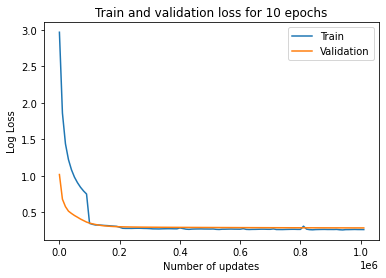

In [ ]:
x = [10000*i for i in range(len(training_losses))]
plt.plot(x, training_losses, label='Train')
plt.plot(x, validation_losses, label='Validation')
plt.xlabel('Number of updates')
plt.ylabel('Log Loss')
plt.legend(('Train', 'Validation'))
plt.title(f'Train and validation loss for {n_epochs} epochs')
plt.show()

La pénalisation L2 et l'ajout de termes croisés empêchent l'overfitting. Après plusieurs passages sur la base de données on obtient des erreurs de validation et d'apprentissage semblables.

# Answer question 2

In [14]:
X_test = 'X_test.csv'
y_test = 'y_test_csv'
#We take a subset of the test set to perform hyperparameter search.
!sed -n 1,60000p X_test.csv > X_opt.csv #CARE we took 10k lines from test as validation.
!sed -n 1,60000p y_test.csv > y_opt.csv
X_opt = 'X_opt.csv'
y_opt = 'y_opt.csv'

We install wandb in our machine.

In [16]:
#!pip install wandb
!wandb login 

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


We define the range of the parameters we want to optimize.

In [24]:
import wandb
sweep_config = {
      "name" : "TP1-hyperparameter_search",
      "method" : "random", #There exist several strategies such as Bayes and it possible to add some early stopping (see Hyperband). Care NCE is not a loss (higher is better)
      "parameters" : {
        "learning_rate" :{
          "min": 0.0001,
          "max": 0.1
        },
        "l2":{
          "min": 0.,
          "max": 0.1
        },
        "k":{
          "min": 2,
          "max": 20
        },
      }
}
sweep_id = wandb.sweep(sweep_config)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 9y7cmh0t
Sweep URL: https://wandb.ai/mrouault/uncategorized/sweeps/9y7cmh0t


epoch,▁▁▁▁▅▅▅▅▅██
loss,█▅▃▄▂▂▄▂▃▁▂
n_updates,▁▂▂▃▄▄▅▆▇▇█
epoch,2
loss,0.26399
n_updates,110000


We train our model on the subset of test, for a grid of hyperparameters.

In [25]:
def train():
    with wandb.init(reinit=True) as run:
        config = wandb.config
        D = 2 ** 24
        w = [0.] * D  
        n = [0.] * D
        alpha = .01
        n_epochs = 5
        loss = 0.
        n_updates = 0
        v = np.full(shape = (D, config['k']), fill_value = -1)

        for e in range(n_epochs):
            for t, (row, y)  in enumerate(zip(DictReader(open(X_opt)), DictReader(open(y_opt)))):
                if t > 10000 : #we already took the 10k first rows for the validation set
                    x = get_x(row, D)
                    p = get_p_factorization(x, w, v, config['k'])
                    target = float(y['click'])
                    if n_updates% 10000 == 0 and n_updates>1:
                        wandb.log({"loss": compute_validation_loss_factorization(w, D, v, config['k']),
                                 "epoch": e,"n_updates":n_updates})
                    w, v, n = update_wL2_factorization(w, v, n, x, p, target, config['k'])  
                    n_updates += 1

count = 10 #Indeed the more the better and longer
#Using the same sweep_id it is also possible to distribute the training
wandb.agent(sweep_id, function=train, count=count) 

wandb: Agent Starting Run: nj67zzl6 with config:
wandb: 	k: 12
wandb: 	l2: 0.029990440969796903
wandb: 	learning_rate: 0.07866012713676636


epoch,▁▁▁▁▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆█████
loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
n_updates,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
epoch,4
loss,0.57849
n_updates,240000


wandb: Agent Starting Run: 8t8c04tx with config:
wandb: 	k: 10
wandb: 	l2: 0.05624933193353021
wandb: 	learning_rate: 0.01626986101165927


wandb: Ctrl + C detected. Stopping sweep.


Here are the plots produces on wandb :

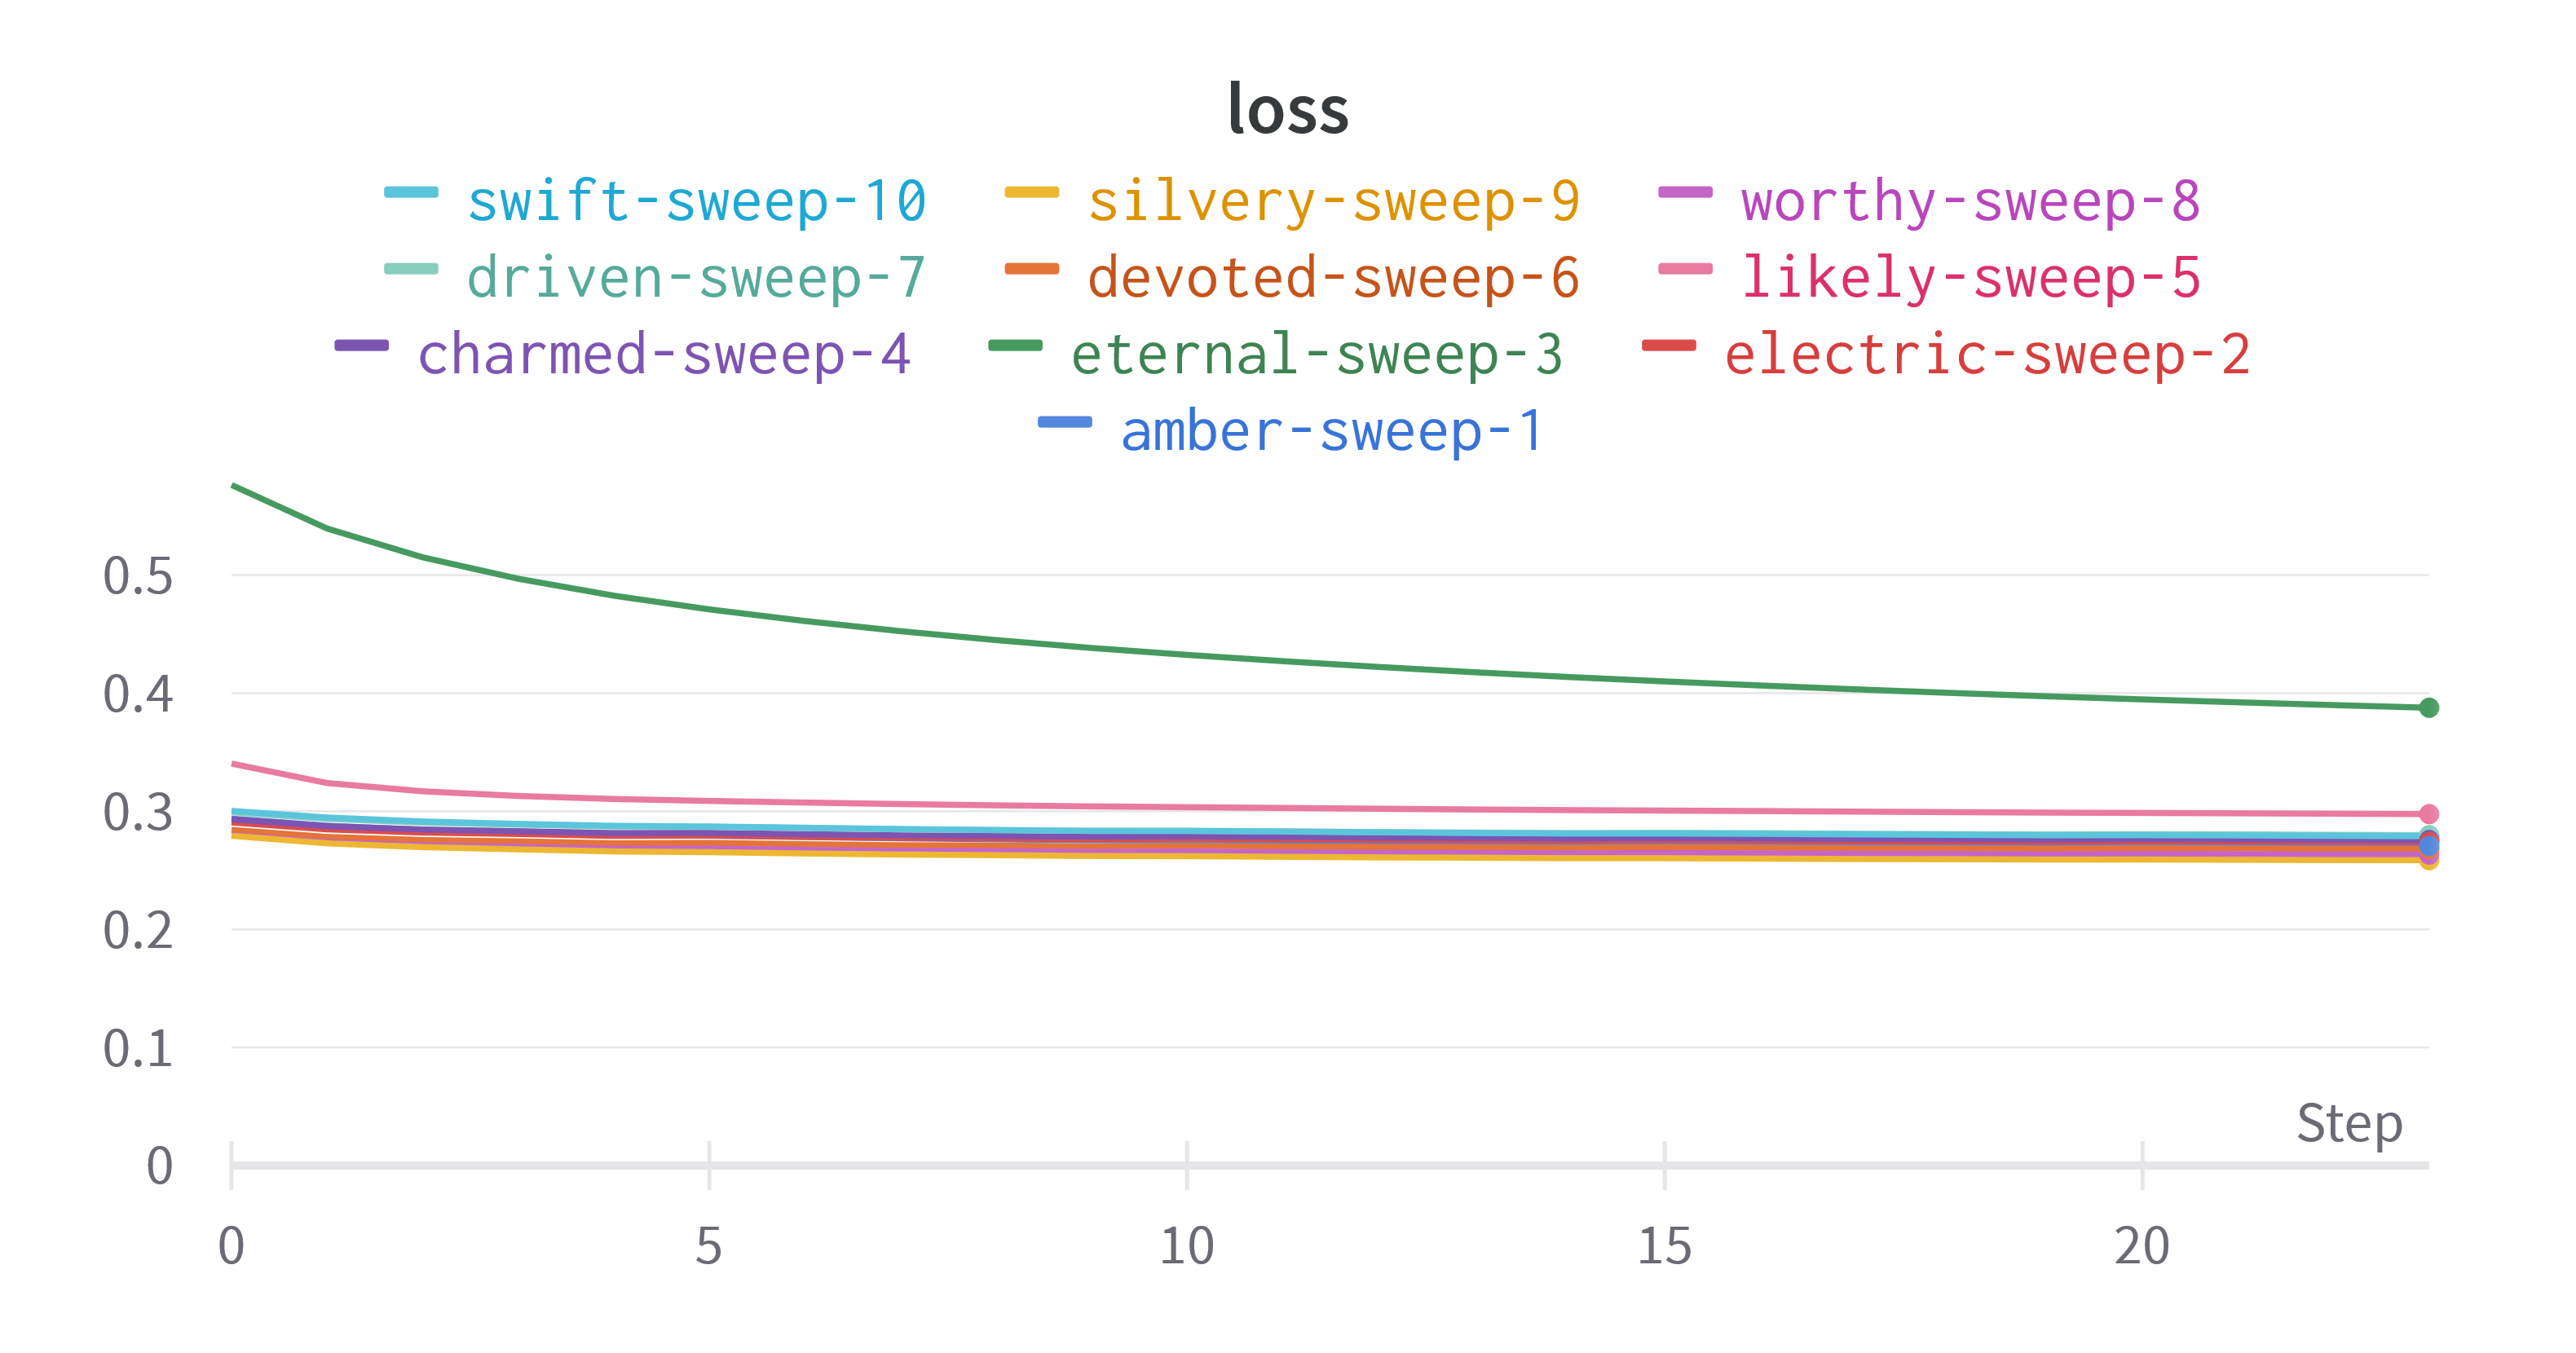

In [7]:
from IPython.display import Image
Image(filename='lossv1.png', width = 500)

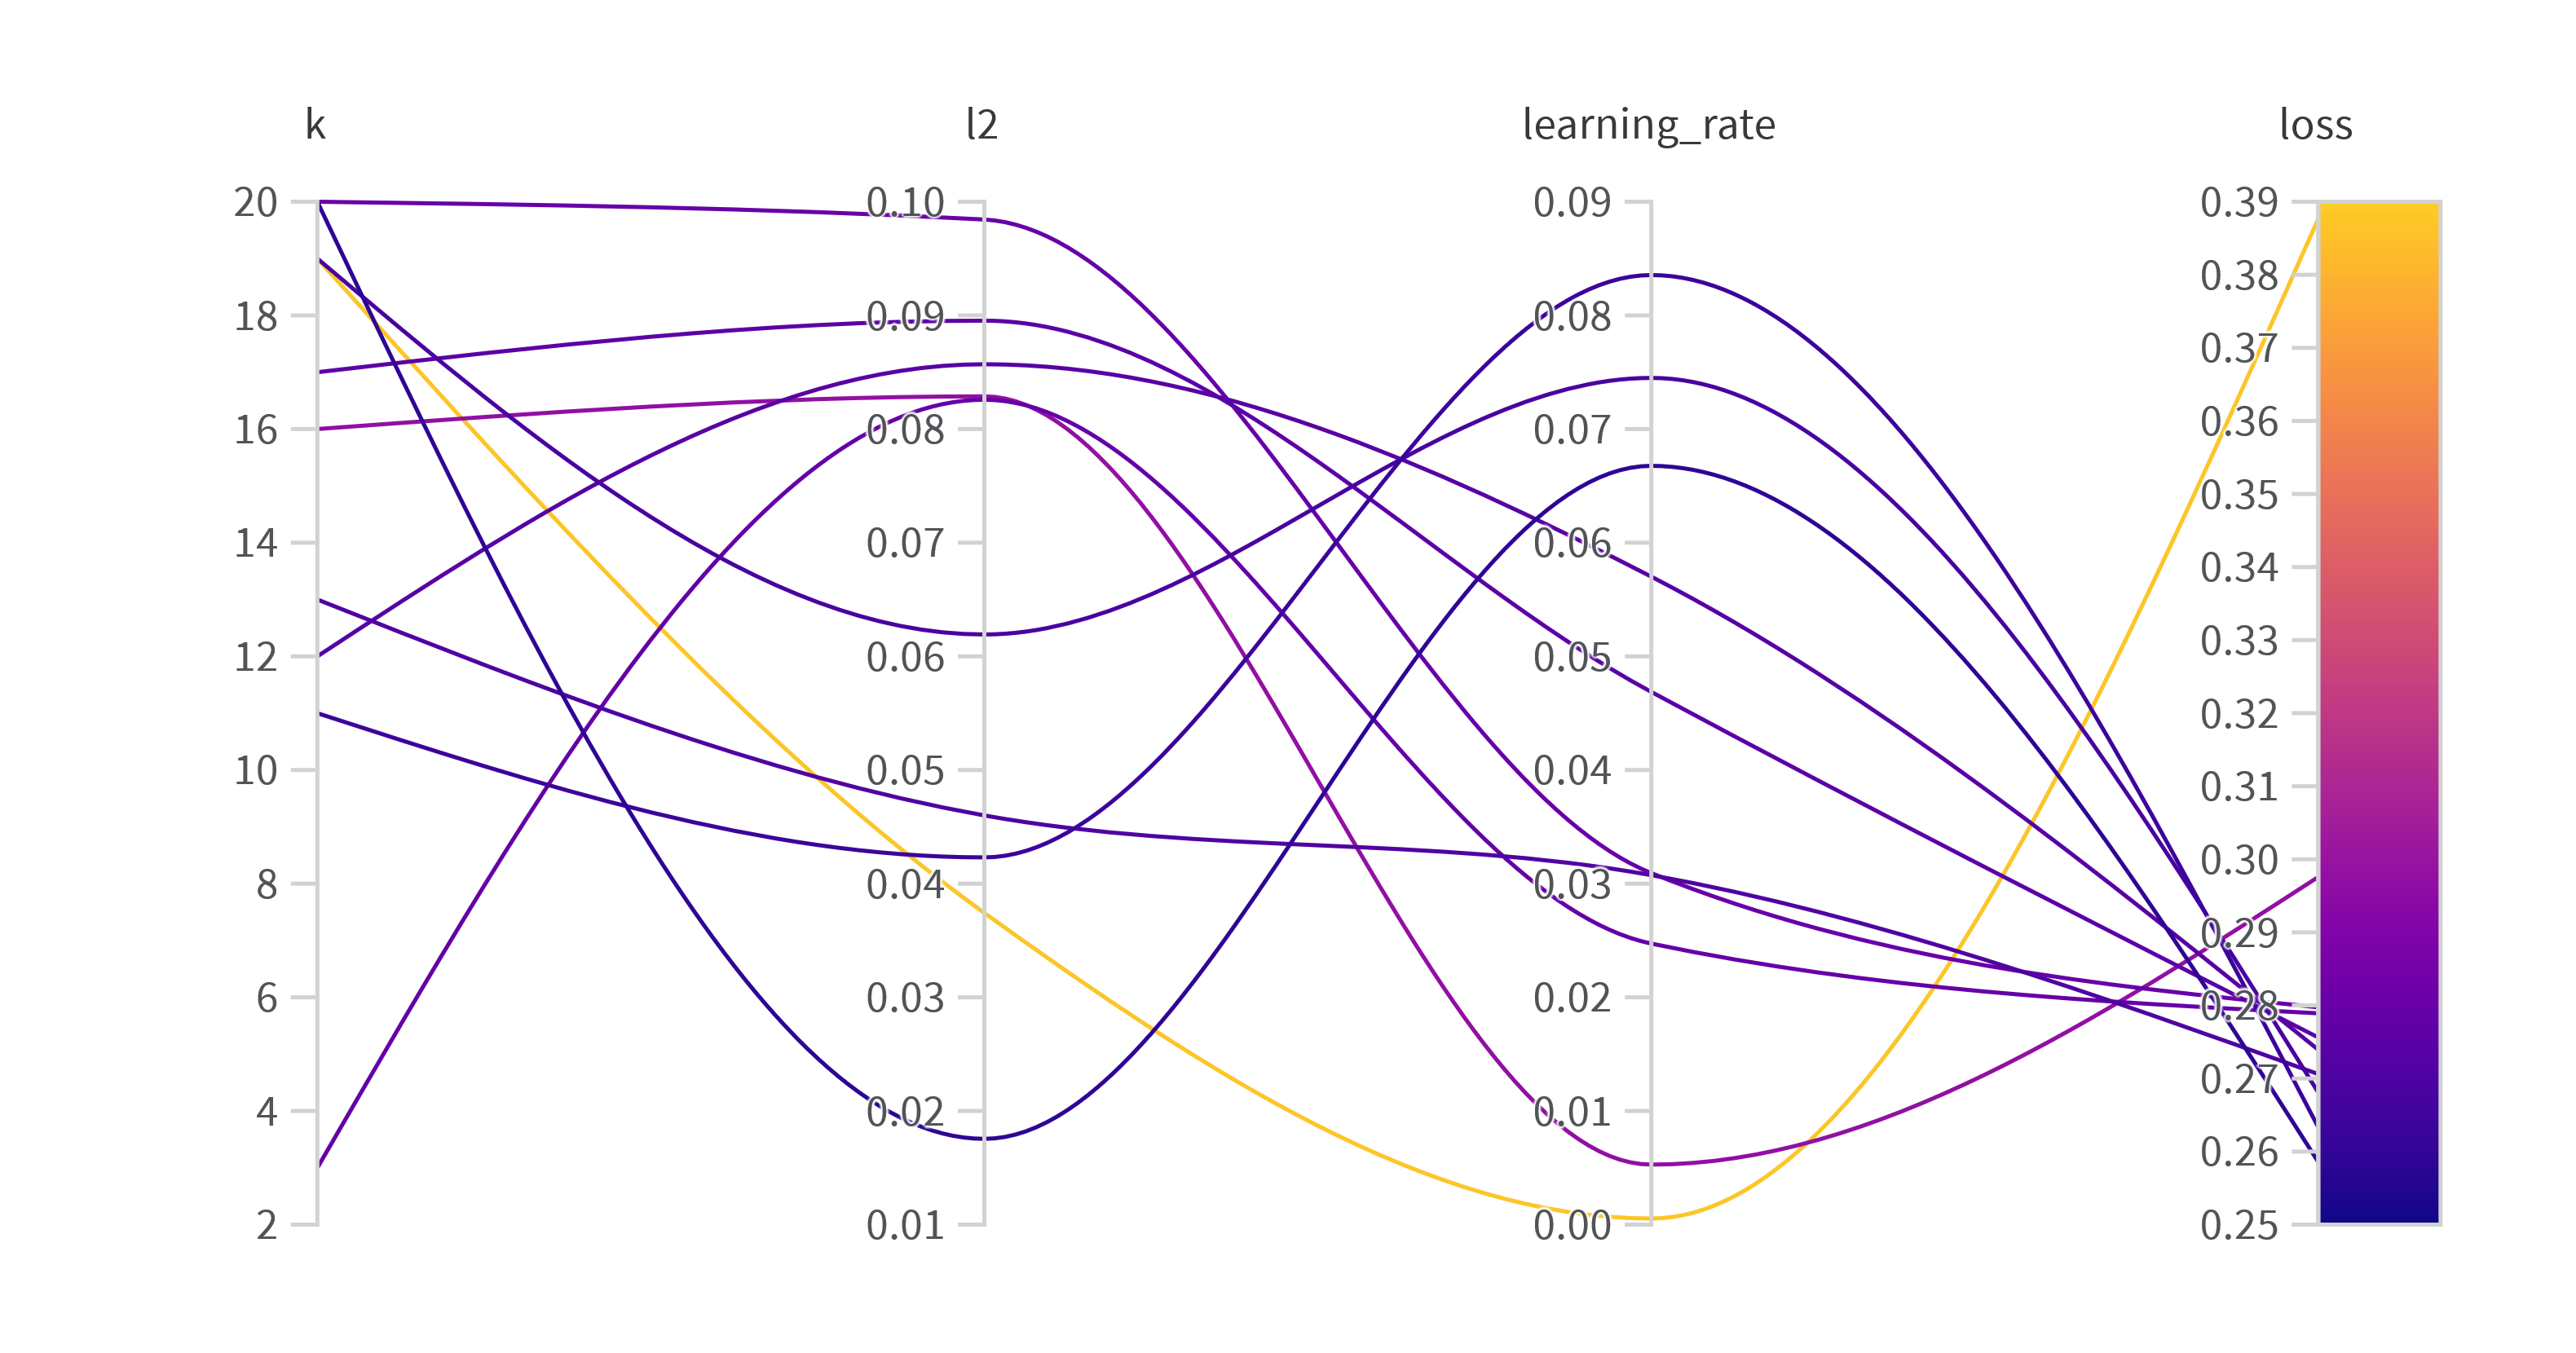

In [9]:
Image(filename='optv1.png', width = 500)

We can try to perform the optimization on different data set sizes, here is the result for a bigger dataset (100k rows) :

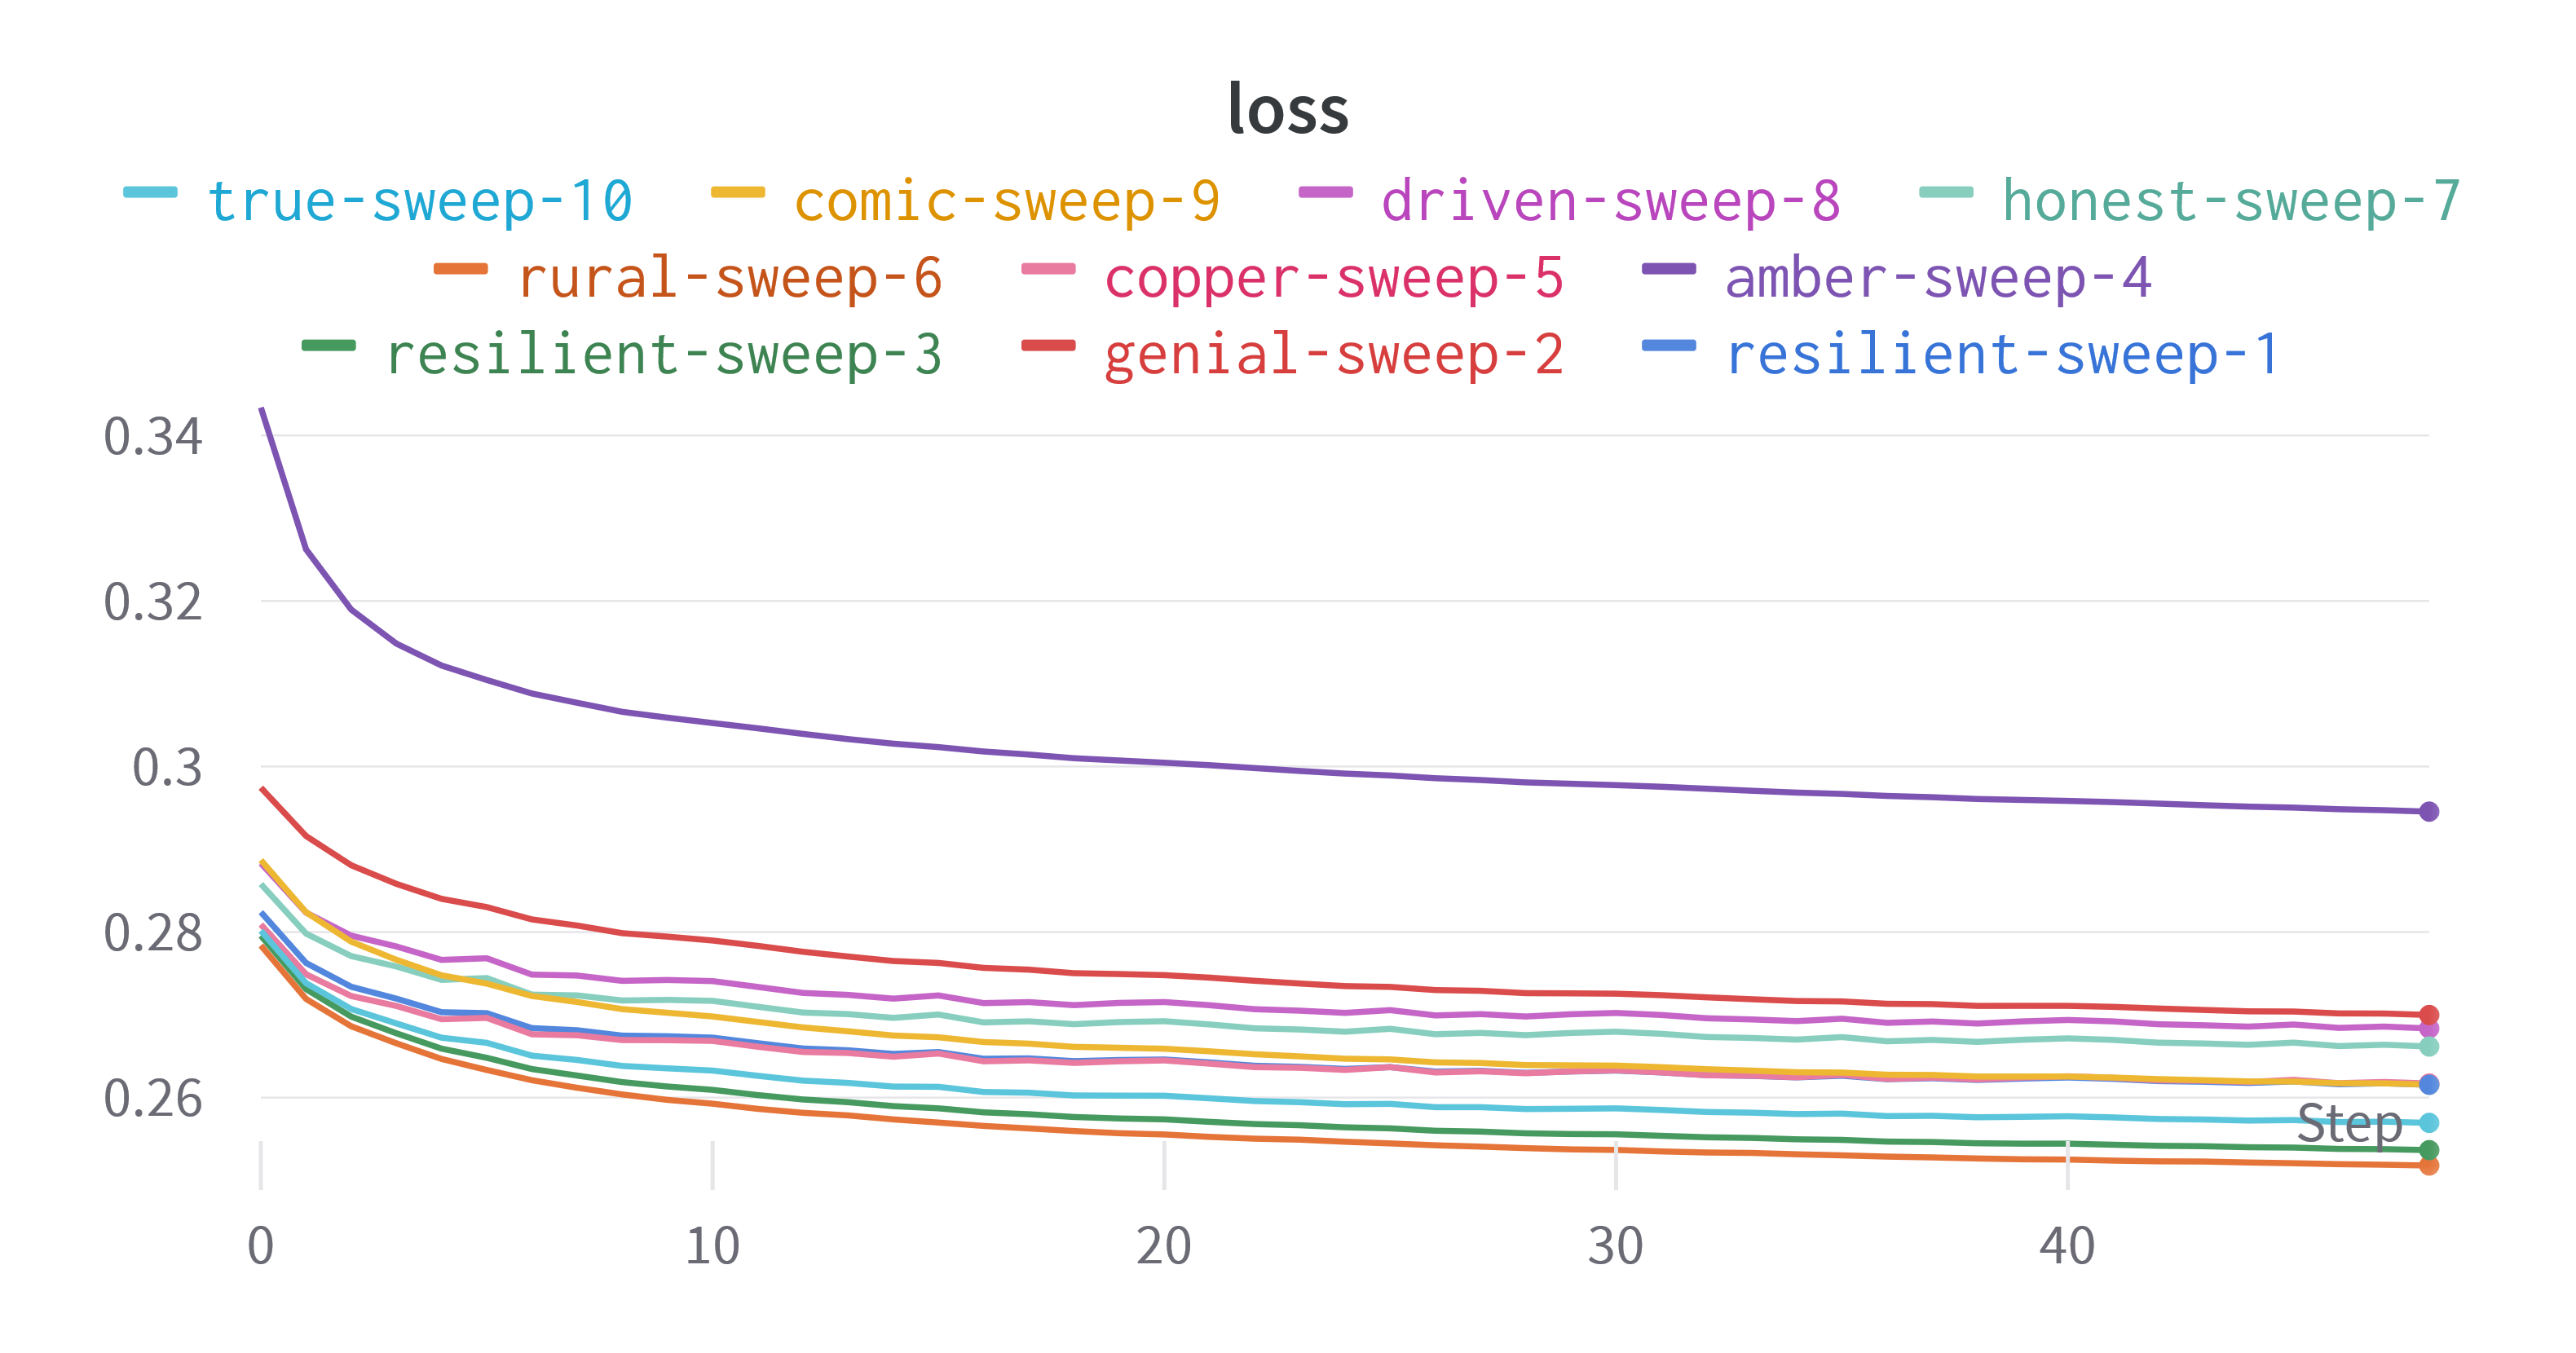

In [10]:
Image(filename='lossv2.png', width = 500)

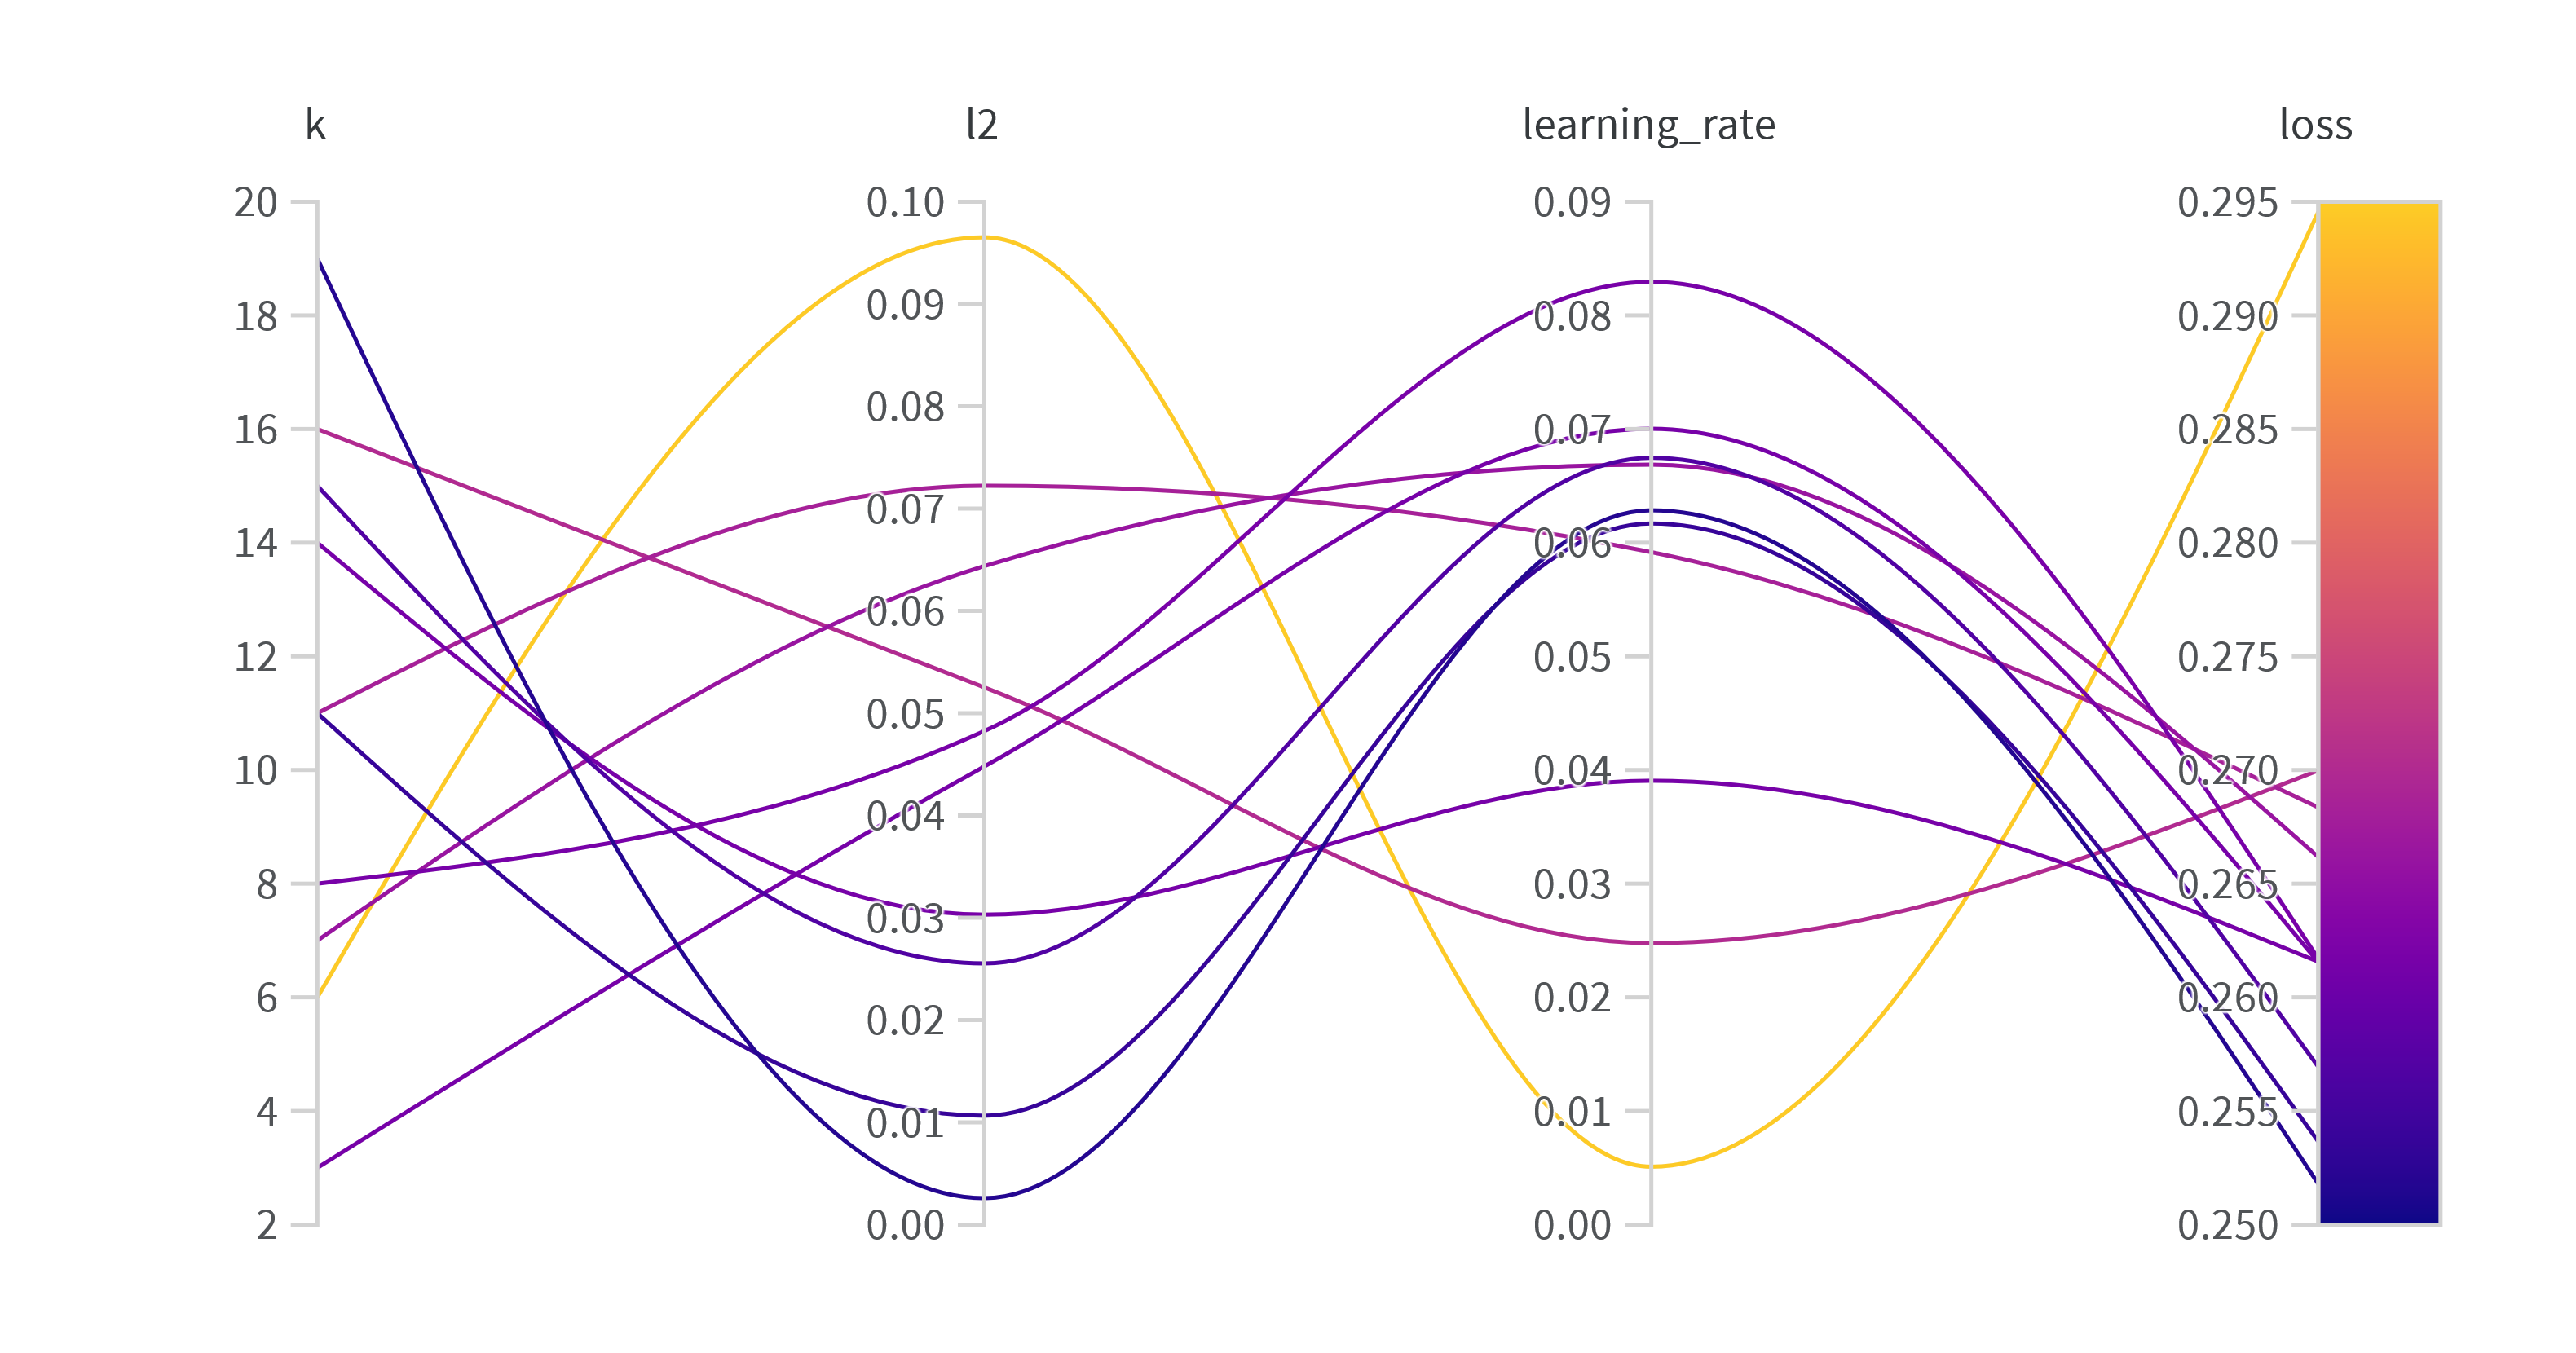

In [11]:
Image(filename='optv2.png', width = 500)

We observe bad results for minimal learning rates, which is not that surprising as the gradient descent does not move enough. Large or small L2 penalization does not seem to have much effect on the resulting loss, neither do large or small values of k.